# Hypersphere
> Extend decision trees to hyperspherical manifolds!

This code is largely adapted from the 14_fixed_hyperbolic_gaussian.ipynb notebook.

In [2]:
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from geomstats.geometry.hypersphere import Hypersphere
from geomstats.visualization import plot as gplot

from src.hyperdt.tree import HyperbolicDecisionTreeClassifier


In [64]:
# Modified version of hdt class


class HypersphereDecisionTreeClassifier(HyperbolicDecisionTreeClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _validate_hyperbolic(self, X):
        # Basically just skip the check
        pass

    def _get_candidates(self, X, dim):
        # Consider tangents
        thetas = np.arctan2(X[:, self.timelike_dim], X[:, dim])
        thetas = np.unique(thetas)  # This also sorts
        candidates = (thetas[:-1] + thetas[1:]) / 2
        return candidates


In [103]:
# Sample a gaussian mixture from a hypersphere

manifold = Hypersphere(dim=2)

np.random.seed(42)

means = manifold.random_von_mises_fisher(kappa=1, n_samples=3)
kappas = np.random.uniform(10, 20, size=3)
n_samples = 1000

points = []
labels = []
for sample in range(n_samples):
    idx = np.random.choice(range(3))
    mean = means[idx]
    kappa = kappas[idx]

    points.append(manifold.random_von_mises_fisher(mean, kappa))
    labels.append(idx)

points = np.array(points)
labels = np.array(labels)


<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

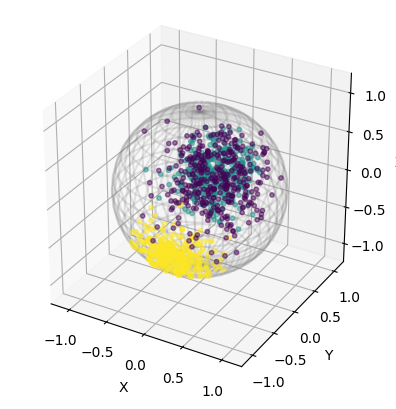

In [104]:
# Plot in 3-D

gplot(points, space="S2", marker="o", s=10, alpha=0.5, c=labels)

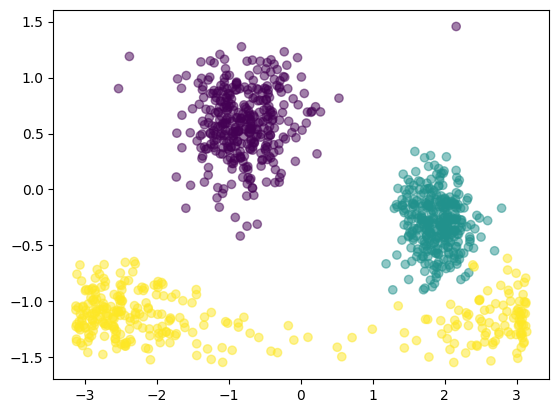

In [105]:
# Project to 2-D (Mercator)


def mercator_projection(points):
    """
    Perform Mercator projection from 3D to 2D for coordinates on a unit sphere.
    Assumes x, y, and z are NumPy arrays and ||x|| = 1.
    """

    # Calculate latitude (phi)
    phi = np.arcsin(points[:, 2])

    # Calculate longitude (lambda)
    lambda_ = np.arctan2(points[:, 1], points[:, 0])

    return np.stack([lambda_, phi], axis=1)


points_2d = mercator_projection(points)

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=labels, alpha=0.5)


In [106]:
# Try it out:

X_train, X_test, y_train, y_test = train_test_split(
    points, labels, test_size=0.2, random_state=0
)

# Hypersphere
hsdt = HypersphereDecisionTreeClassifier(max_depth=5)
hsdt.fit(X_train, y_train)
y_pred = hsdt.predict(X_test)
print("Hypersphere:", accuracy_score(y_test, y_pred))

# Euclidean
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Euclidean:", accuracy_score(y_test, y_pred))


Hypersphere: 0.97
Euclidean: 0.99


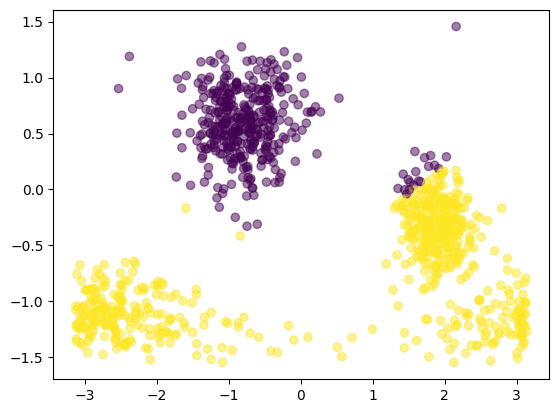

In [107]:
# Let's visualize a decision boundary: hypersphere case

node = hsdt.tree # Can vary this
colors = np.sign(hsdt._dot(points, node.feature, node.theta))

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=colors, alpha=0.5)


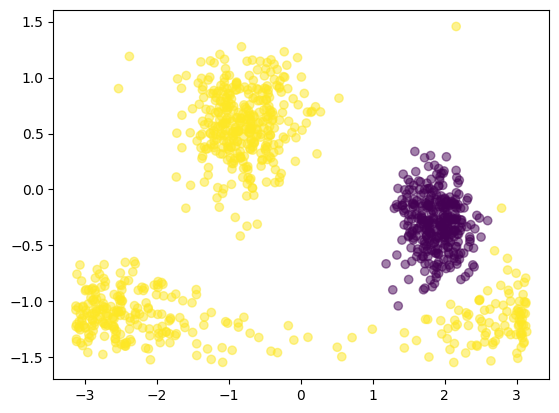

In [120]:
# Let's visualize a decision boundary: hypersphere case

index = 0
colors = points[:, dt.tree_.feature[index]] < dt.tree_.threshold[index]

plt.scatter(points_2d[:, 0], points_2d[:, 1], c=colors, alpha=0.5)